## Visualizing Model Features, GradCAM, and Patch Encoding

In this file, we explore various aspects related to deep learning models, feature visualization, and image processing. The code in this file covers the following key sections:

### Feature Map Visualization
- We use a VGG16 backbone to extract feature maps from the model.
- The code defines a custom function to identify convolutional layers and extract feature maps.
- Feature maps are visualized for inspection and analysis.

### GradCAM (Gradient-weighted Class Activation Mapping)
- We leverage an EfficientNetB5 model for GradCAM, a technique for visualizing which parts of an image are important for predictions.
- The code implements GradCAM to highlight regions that influence model predictions.

### Patch Encoding
- We extract patches from an image using TensorFlow's image patch extraction utility.
- The patches are visualized for better understanding.

### Custom Residual Network (ResNet34)
- We define a custom ResNet34 architecture.
- This architecture includes custom convolutional layers and residual blocks for deep feature extraction.

These sections offer insights into feature visualization, model interpretability, and custom network design. You can use this code as a reference or for educational purposes, adapting it to your specific deep learning tasks and projects.


In [7]:
pip install albumentations seaborn

Note: you may need to restart the kernel to use updated packages.


In [24]:
import tensorflow as tf
from tensorflow.keras import Sequential, Model

from tensorflow.keras.layers import (
    Normalization, Dense, InputLayer, Conv2D, GlobalAveragePooling2D,
    MaxPool2D, Flatten, BatchNormalization, Input, MaxPooling2D,
    Layer, Dropout, RandomFlip, RandomRotation, Permute,
    Resizing, Rescaling, RandomContrast, Activation, Add)

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ( Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)

from tensorflow.keras.metrics import (
    SparseTopKCategoricalAccuracy, SparseCategoricalAccuracy,
    BinaryAccuracy, Accuracy, Precision, Recall, TruePositives,
    TrueNegatives, FalsePositives, FalseNegatives, AUC,
    CategoricalCrossentropy, SparseCategoricalCrossentropy,
    CategoricalAccuracy, TopKCategoricalAccuracy)


from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.image import flip_up_down, flip_left_right
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from tensorboard.plugins.hparams import api as hp
import tensorflow_probability as tfp
import albumentations as A
import seaborn as sns
import matplotlib.pyplot as plt
# import plotly.graph_objs as ff
# import plotly.graph_objects as go
import numpy as np
import datetime
import cv2 as cv
from sklearn.metrics import confusion_matrix, roc_curve
import time
# from sklearn.metrics import confusion_matrix, roc_curve
import pandas as pd

In [9]:
train_dir = "/kaggle/input/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/train"
test_dir = "/kaggle/input/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/test"
class_names = ["angry", "happy", "sad"]

configrations = {"image_size": 256,
                 "batch_size": 32,
                 "learning_rate": 0.001,
                 "n_epochs": 50,
                 "dropout_rate": 0.2,
                 "regularization_rate": 0.0,
                 "n_fliters_1": 128,
                 "n_fliters_2": 64,
                 "kernal_size": 3,
                 "n_strides": 1,
                 "pool_size": 2,
                 "n_dense_1": 256,
                 "n_dense_2": 128,
                 "n_class": 3,
                 "class_names": class_names,
}

In [10]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=configrations["batch_size"],
    image_size=(configrations["image_size"], configrations["image_size"]),
    shuffle=True,
    seed=99
)

Found 6799 files belonging to 3 classes.


In [11]:
val_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=configrations["batch_size"],
    image_size=(configrations["image_size"], configrations["image_size"]),
    shuffle=True,
    seed=99
)

Found 2278 files belonging to 3 classes.


In [12]:
for item in val_data.take(1):
    print(item)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[ 20.        ,  20.        ,  20.        ],
         [ 19.1875    ,  19.1875    ,  19.1875    ],
         [ 19.        ,  19.        ,  19.        ],
         ...,
         [ 29.125     ,  29.125     ,  29.125     ],
         [ 25.        ,  25.        ,  25.        ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.        ,  20.        ,  20.        ],
         [ 19.847656  ,  19.847656  ,  19.847656  ],
         [ 19.8125    ,  19.8125    ,  19.8125    ],
         ...,
         [ 28.820312  ,  28.820312  ,  28.820312  ],
         [ 25.660156  ,  25.660156  ,  25.660156  ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.6875    ,  20.6875    ,  20.6875    ],
         [ 21.246094  ,  21.246094  ,  21.246094  ],
         [ 21.847656  ,  21.847656  ,  21.847656  ],
         ...,
         [ 25.3125    ,  25.3125    ,  25.3125    ],
         [ 22.375     ,  22.375     ,  22.375 

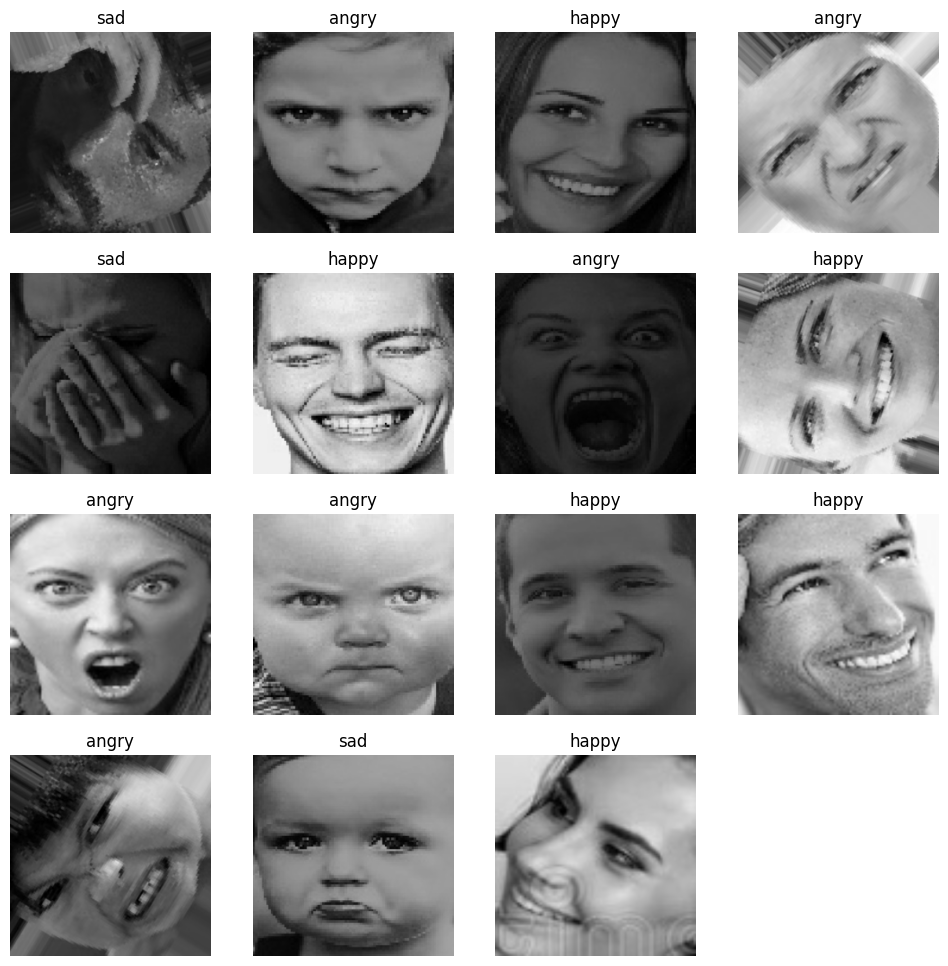

In [13]:
plt.figure(figsize = (12, 12) )

for images, labels in train_data.take(1):
    for i in range(15):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i]/255.0)
        plt.title(class_names[tf.argmax(labels[i], axis=0).numpy()] )  #to show the max number in list
        plt.axis("off")

In [14]:
IMG_SIZE = 224

resize_and_rescale = tf.keras.Sequential([
  Resizing(configrations["image_size"], configrations["image_size"]),
  Rescaling(1./255)
])

In [15]:
augent_layers = tf.keras.Sequential([
    RandomRotation(factor=(-0.025, 0.025)),
    RandomFlip(mode="horizontal"),
    RandomContrast(factor=0.1),

])

In [16]:
def augment_layer(image, label):
    return augent_layers(image, training = True), label

### Feature Map Extraction using VGG16 Backbone

In this section, we use the VGG16 architecture as a backbone model for feature extraction. The VGG16 model is a well-known convolutional neural network architecture that has been pretrained on large datasets.

**Code Explanation**:
- We create a VGG16 model using `tf.keras.applications.vgg16.VGG16`. 
- The `include_top` parameter is set to `False` to exclude the final classification layers, as we are interested in feature extraction.
- We specify `weights=None`, indicating that we do not load pretrained weights. This allows us to work with the model architecture only.
- The `input_shape` is defined based on the project's configuration with an image size of (configurations["image_size"], configurations["image_size"], 3).

This VGG16 backbone will be used to extract feature maps from input images, which can be further visualized and analyzed. The feature maps represent the activations of various convolutional layers in the model and provide valuable information for understanding the learned features.


In [17]:
vgg_backbone = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights=None,
    input_shape=(configrations["image_size"], configrations["image_size"], 3),

)

In [18]:
vgg_backbone.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

### Feature Map Extraction

In this section, we extract feature maps from the VGG16 backbone model created earlier. Feature maps are representations of the activations of various convolutional layers in the model.

**Code Explanation**:
- The `check_conv` function is defined to filter and select layers with the word "conv" in their names. This function returns `True` for convolutional layers and `False` for other layers.

- We create a `feature_map` list by iterating through the layers of the VGG16 backbone model (`vgg_backbone`). We use a list comprehension to select the output of layers that pass the `check_conv` filter.

- A new model, `feature_map_model`, is created using the `Model` class, with the same input as the `vgg_backbone` and the selected feature maps as outputs.

- The summary of the `feature_map_model` is displayed, providing an overview of the architecture and the number of feature maps generated.

This code block allows us to extract and work with feature maps, which can be used for visualization and analysis of the model's learned features.


In [19]:
def check_conv(name):
    if "conv" in name:
        return True
    else:
        return False

In [20]:
feature_map = [layer.output for layer in vgg_backbone.layers[1:] if check_conv(layer.name)]
feature_map

[<KerasTensor: shape=(None, 256, 256, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, 256, 256, 64) dtype=float32 (created by layer 'block1_conv2')>,
 <KerasTensor: shape=(None, 128, 128, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, 128, 128, 128) dtype=float32 (created by layer 'block2_conv2')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv2')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv3')>,
 <KerasTensor: shape=(None, 32, 32, 512) dtype=float32 (created by layer 'block4_conv1')>,
 <KerasTensor: shape=(None, 32, 32, 512) dtype=float32 (created by layer 'block4_conv2')>,
 <KerasTensor: shape=(None, 32, 32, 512) dtype=float32 (created by layer 'block4_conv3')>,
 <KerasTensor: shape=(None, 16, 16, 512) dtype=float32 (created by layer 'block5_con

In [21]:
feature_map_model = Model(
    inputs = vgg_backbone.input,
    outputs = feature_map
)

feature_map_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [22]:
image = cv.imread("/kaggle/input/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/test/angry/101071.jpg_rotation_1.jpg")
test_image = cv.resize(image, (configrations["image_size"], configrations["image_size"]))
im = tf.constant(test_image, dtype=tf.float32)
im = tf.expand_dims(im, axis=0)
f_map = feature_map_model.predict(im)
f_map

1/1 [==============================] - 7s 7s/step


[array([[[[ 0.        ,  0.        ,  0.        , ...,  6.6119847 ,
            0.        , 36.239796  ],
          [16.752296  ,  0.        ,  0.        , ...,  0.        ,
            0.        , 44.2176    ],
          [16.715988  ,  0.        ,  0.        , ...,  0.        ,
            0.        , 42.368977  ],
          ...,
          [ 2.9501886 ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  8.430634  ],
          [ 2.9501886 ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  8.430634  ],
          [ 2.842047  ,  0.        ,  0.        , ...,  0.        ,
            2.760465  ,  3.5441997 ]],
 
         [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
            0.        , 59.00213   ],
          [ 5.5935364 ,  0.        ,  0.        , ...,  0.        ,
            0.        , 48.922234  ],
          [ 5.638059  ,  0.        ,  0.        , ...,  0.        ,
            0.        , 46.87232   ],
          ...,
          [ 1

### Feature Map Visualization

In this section, we visualize the feature maps extracted from the VGG16 backbone model. Feature maps are representations of the activations of various convolutional layers in the model. Visualizing these feature maps can provide insights into the learned features.

**Code Explanation**:
- We iterate through the list of `f_map`, which contains the extracted feature maps.

- For each feature map, we perform the following steps:
  - Display the shape of the feature map to understand its dimensions.

  - Create a figure for visualization with a large size (256x256) to ensure clarity.

  - Calculate the dimensions of the feature map (`f_size`) and the number of channels (`n_channels`).

  - Create a composite image, `joint_maps`, to display all channels of the feature map in a single image.

  - Iterate through the channels and combine them into `joint_maps`.

  - Display the resulting image with the combined feature maps.

- We use exception handling to catch any errors during the visualization process. In case of an error, the code waits for 100 seconds before continuing with the next feature map.

This code block enables the visualization of individual feature maps, providing a better understanding of the patterns and features detected by the convolutional layers of the VGG16 model.


In [23]:
for i in range(len(f_map)):
    print(f_map[i].shape)

(1, 256, 256, 64)
(1, 256, 256, 64)
(1, 128, 128, 128)
(1, 128, 128, 128)
(1, 64, 64, 256)
(1, 64, 64, 256)
(1, 64, 64, 256)
(1, 32, 32, 512)
(1, 32, 32, 512)
(1, 32, 32, 512)
(1, 16, 16, 512)
(1, 16, 16, 512)
(1, 16, 16, 512)


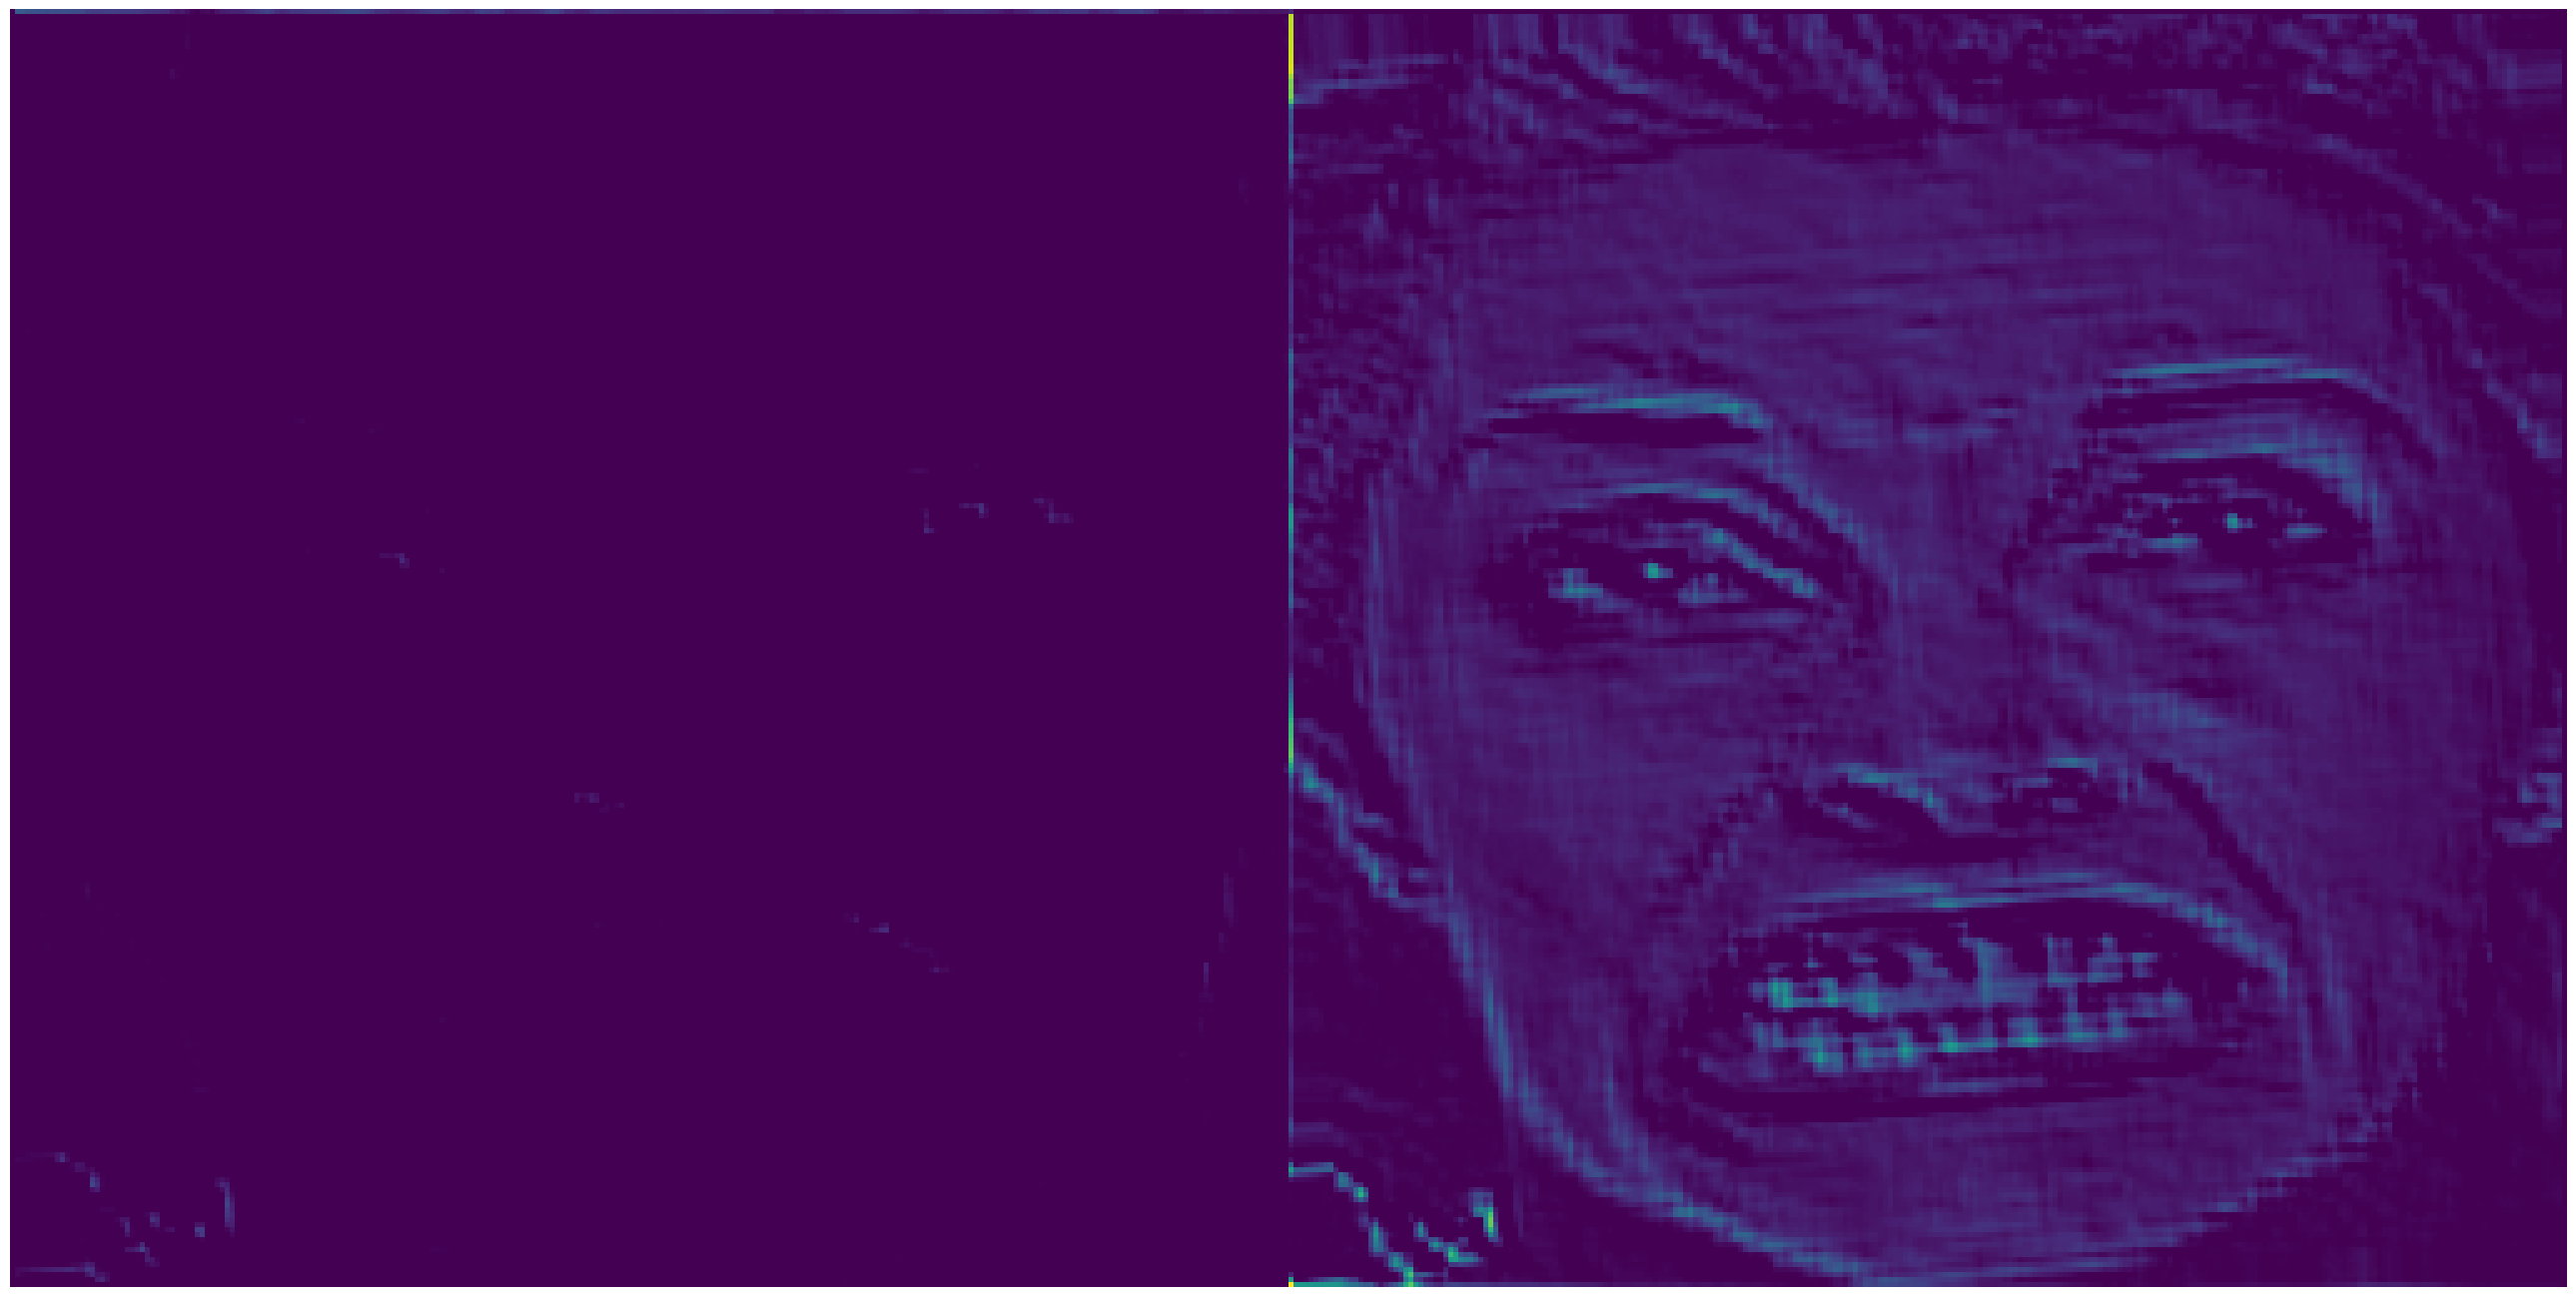

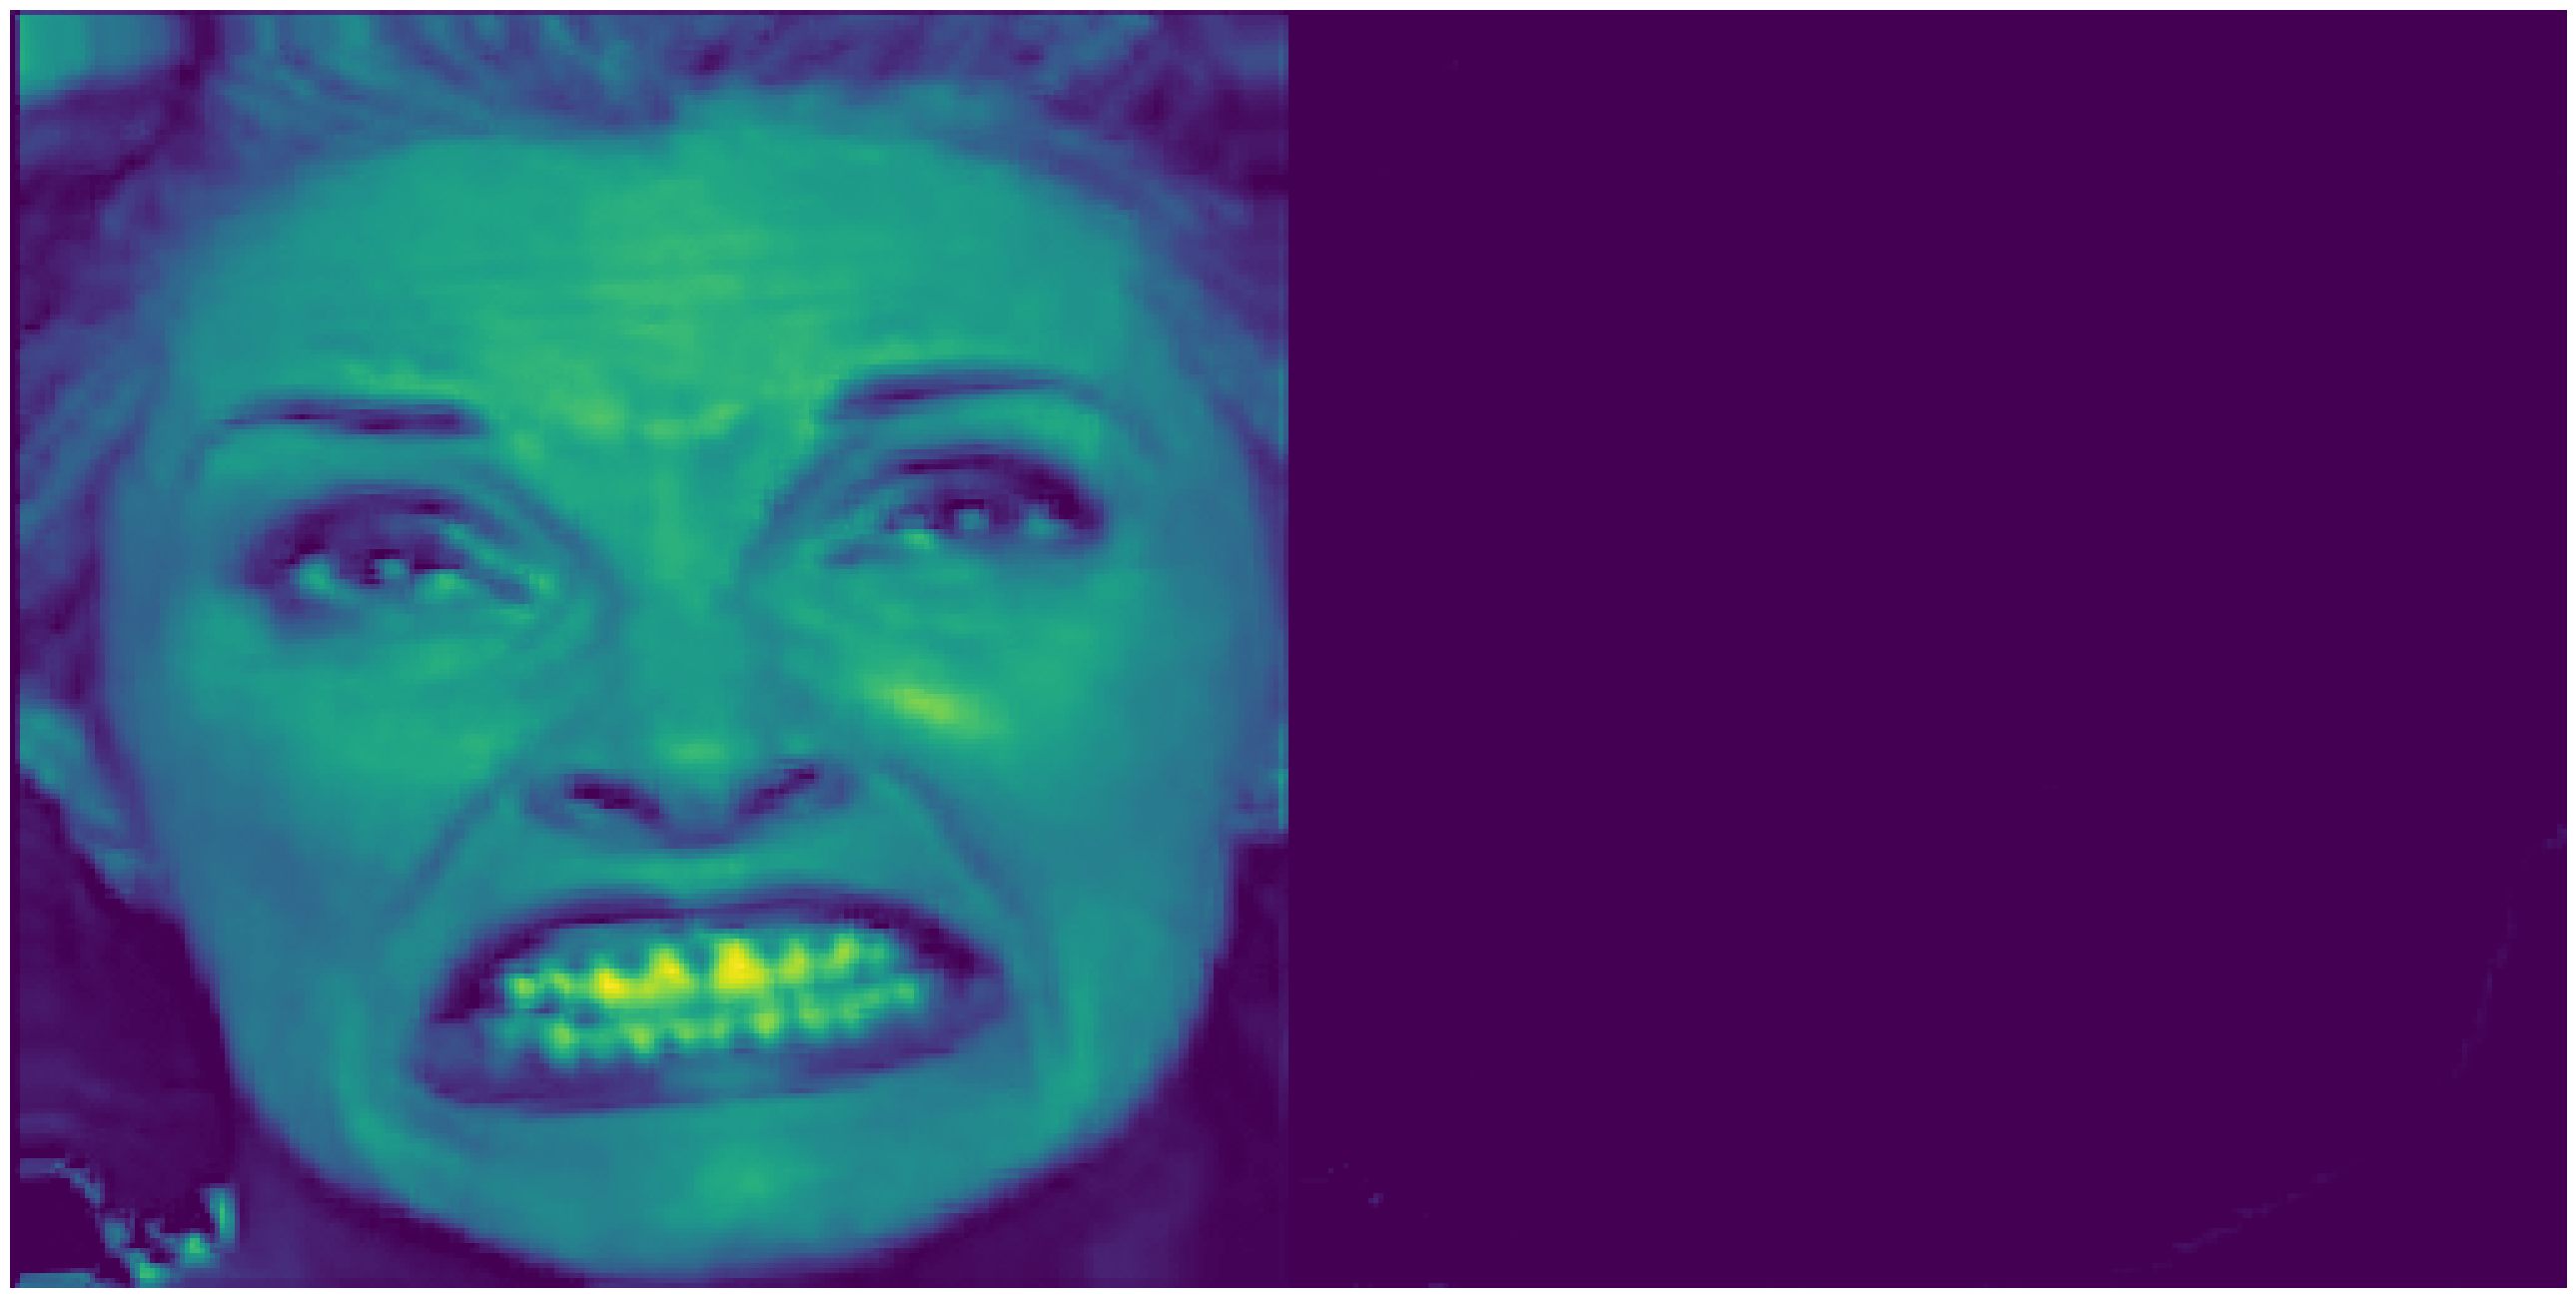

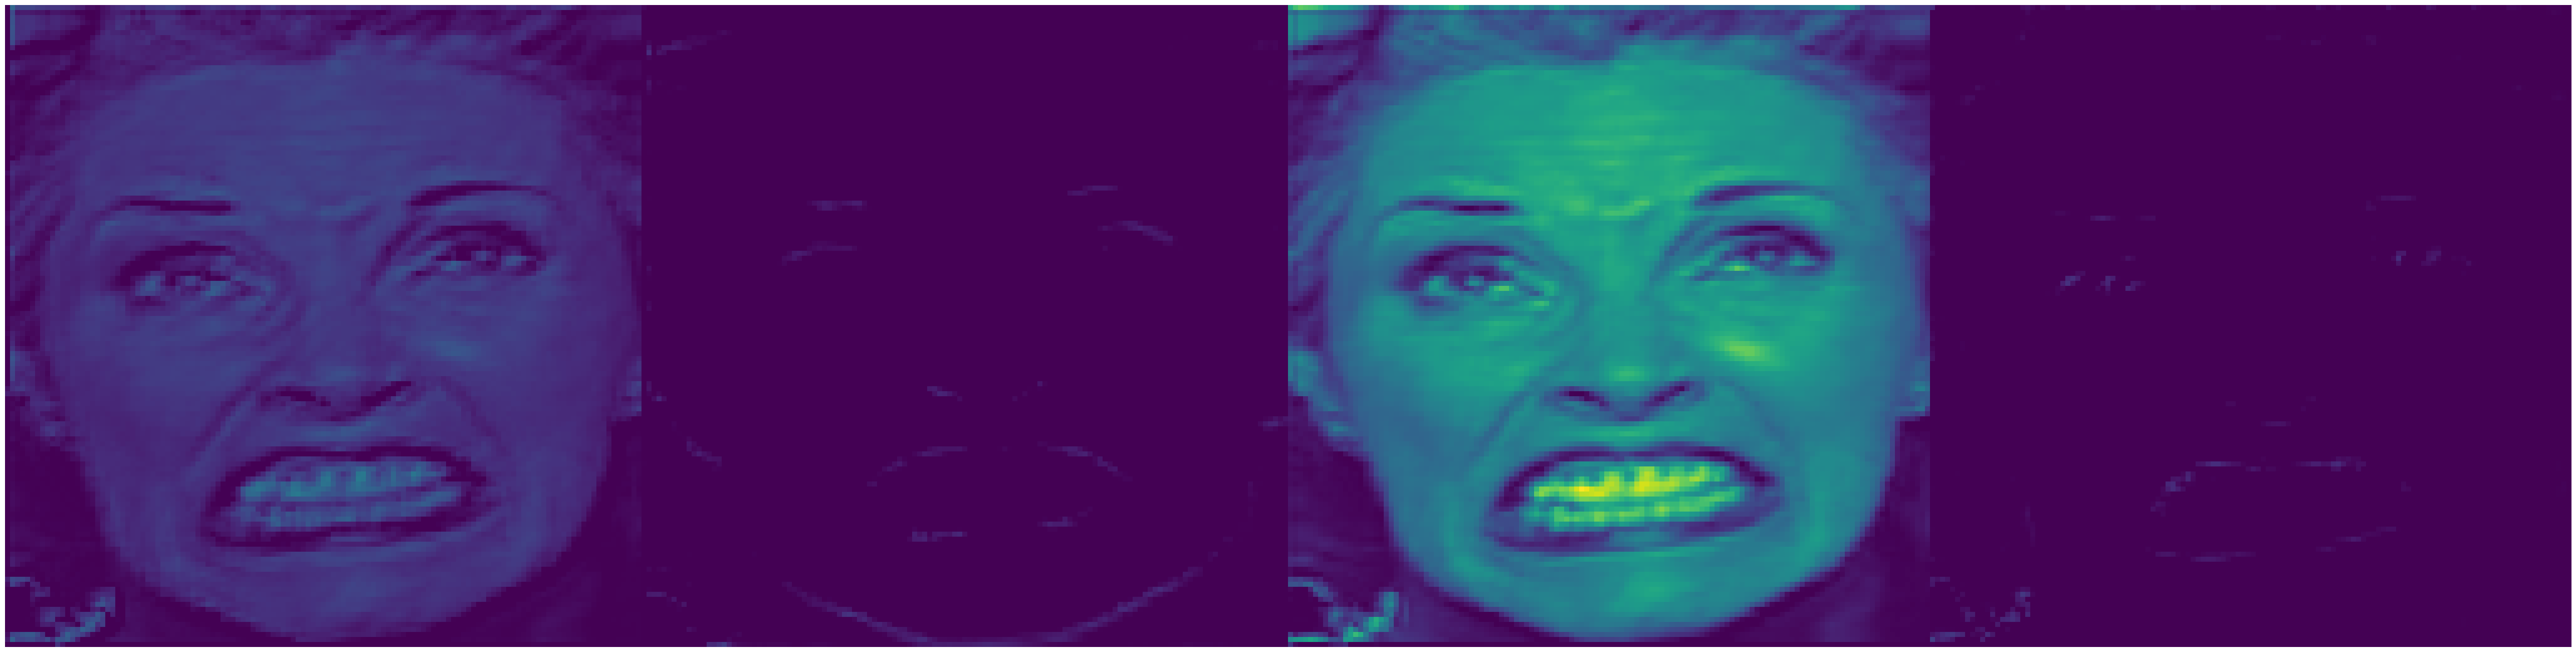

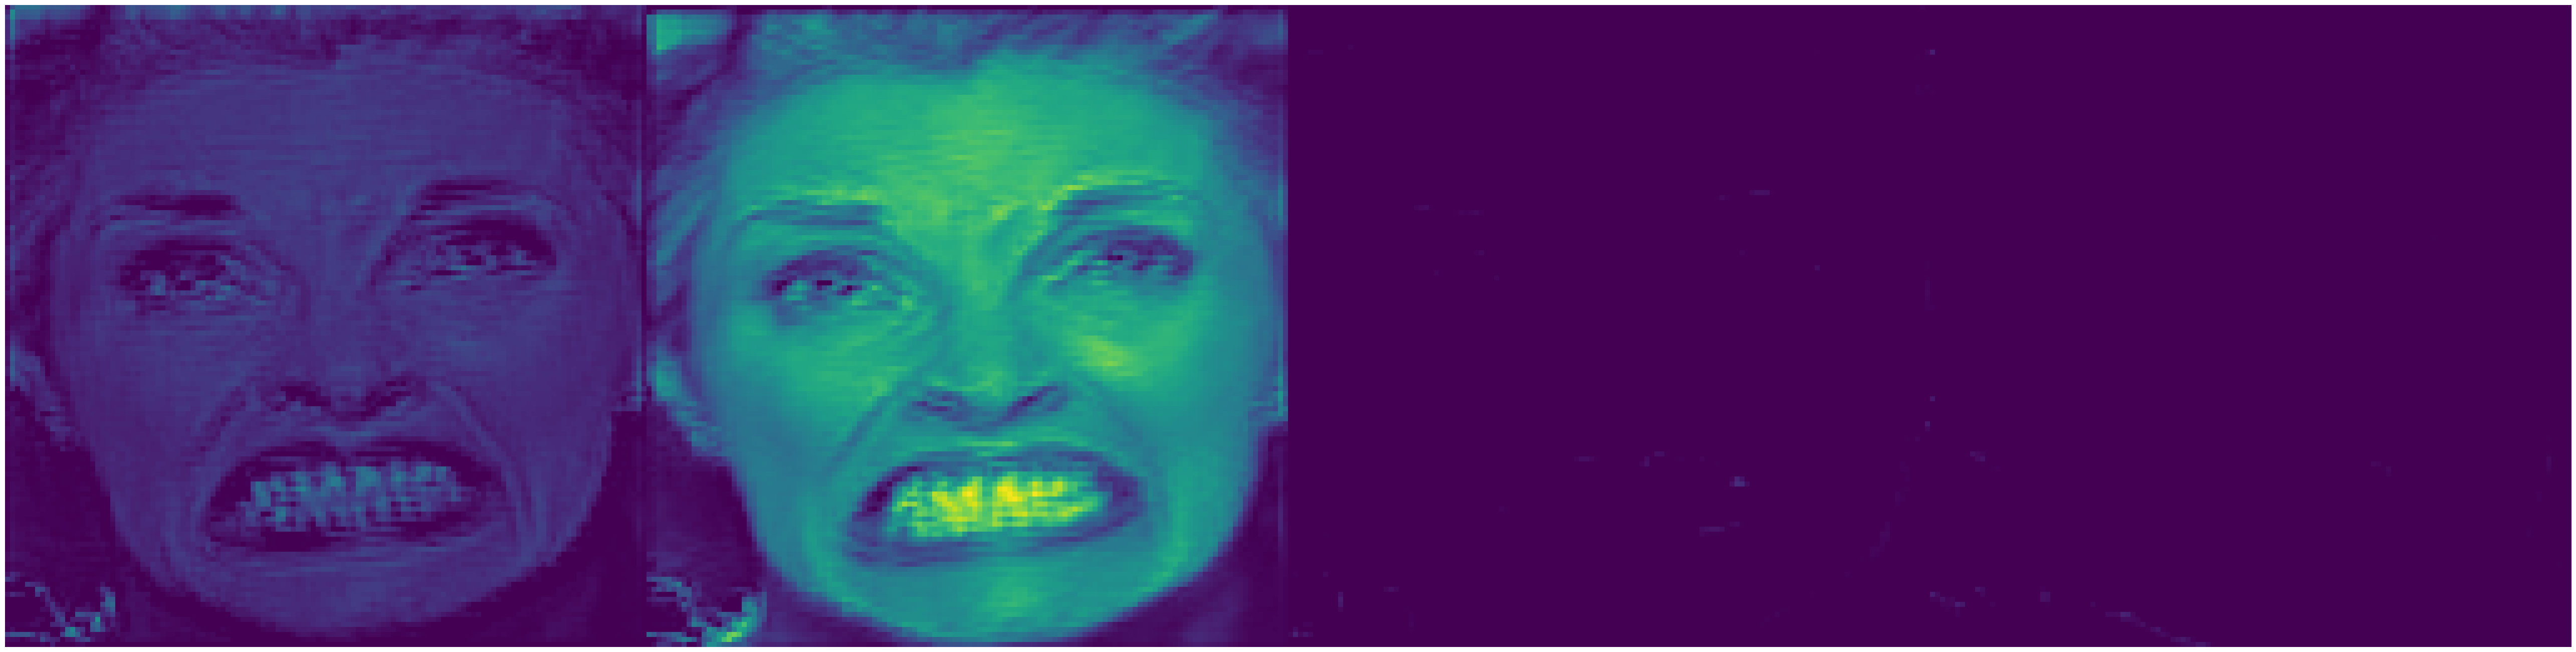

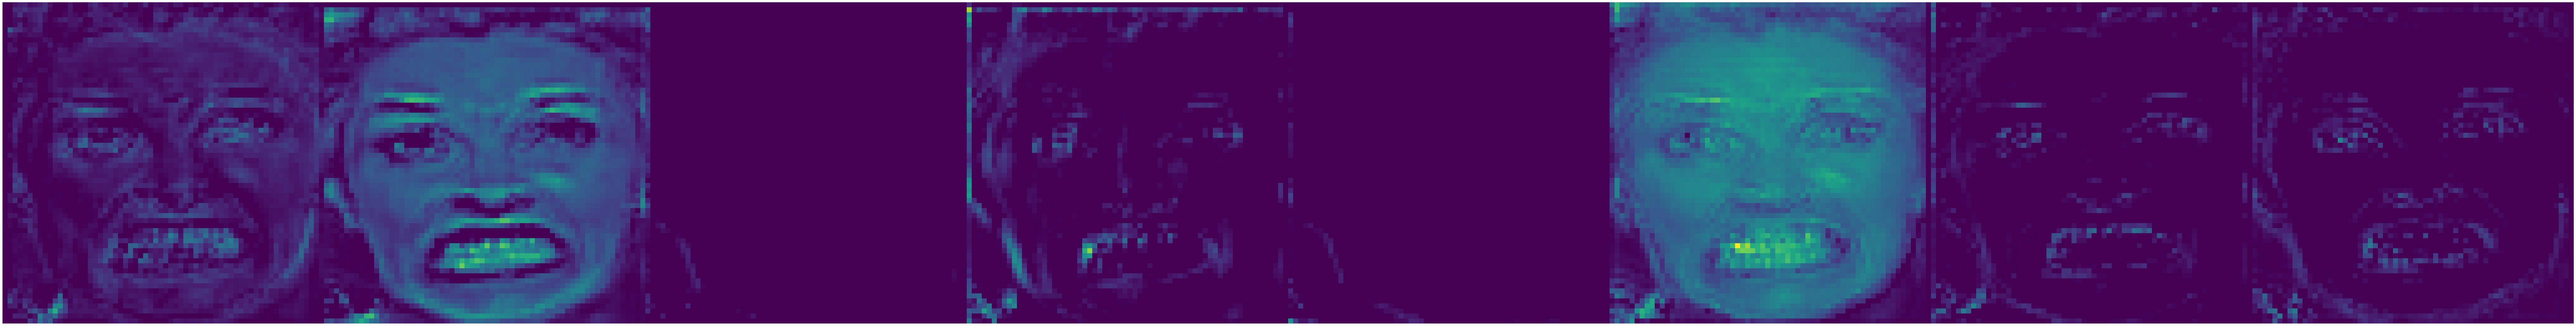

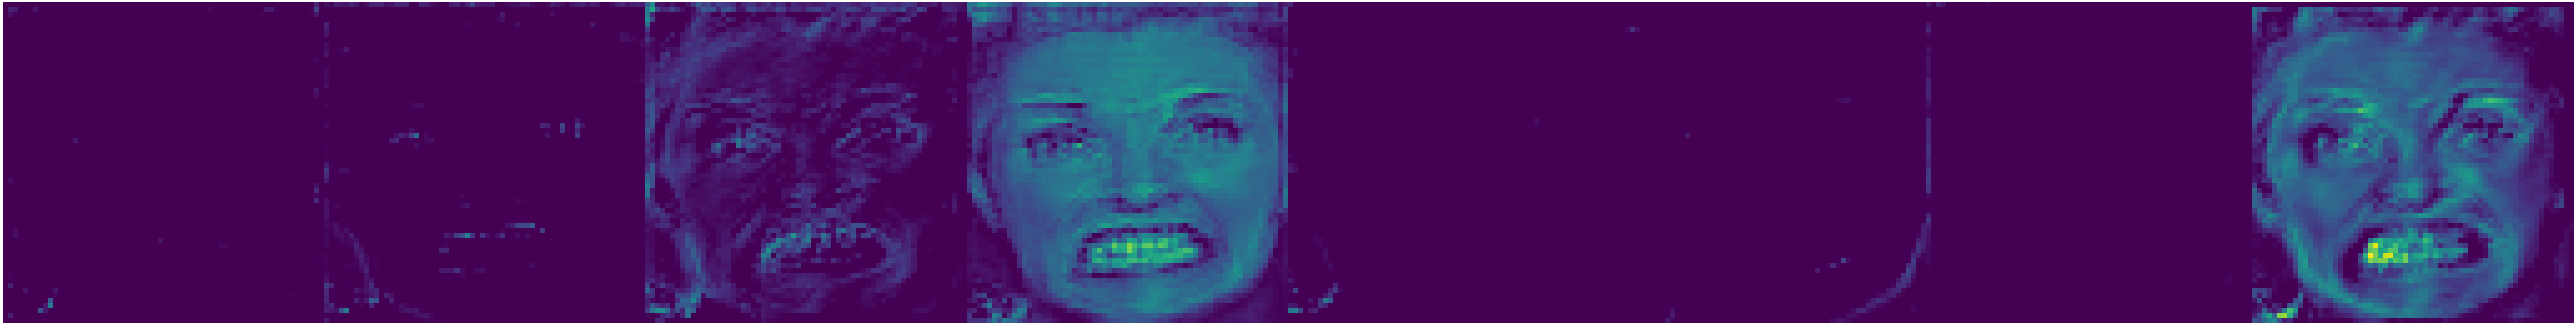

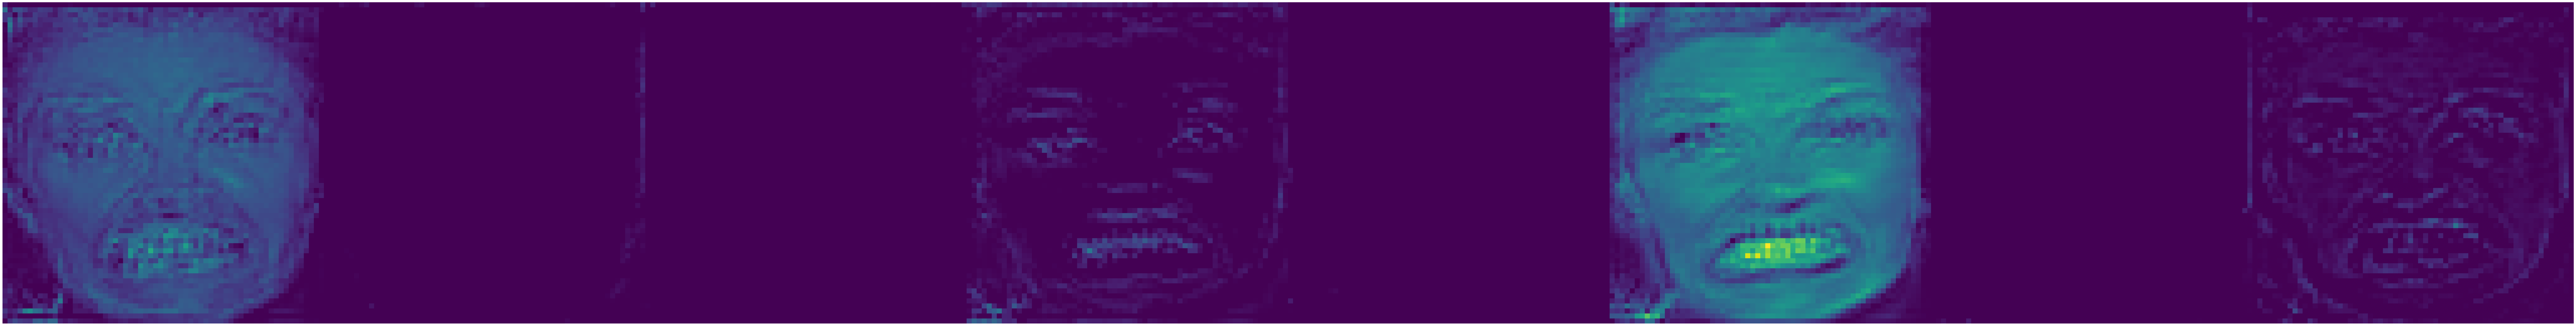

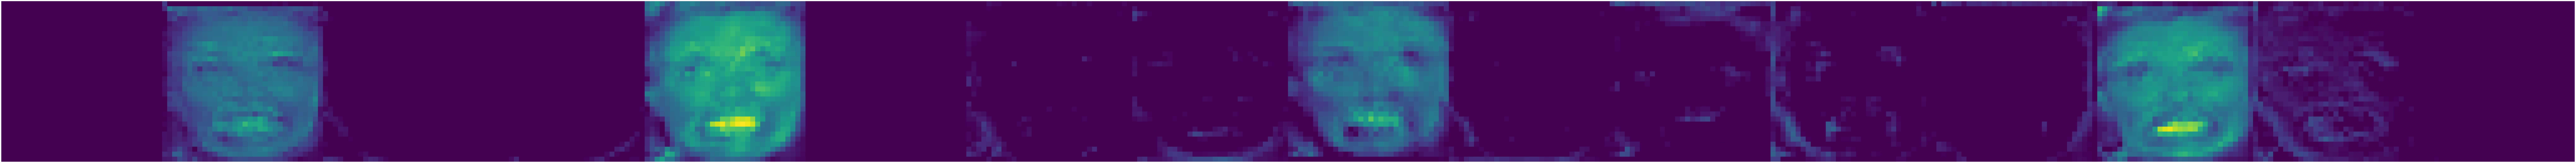

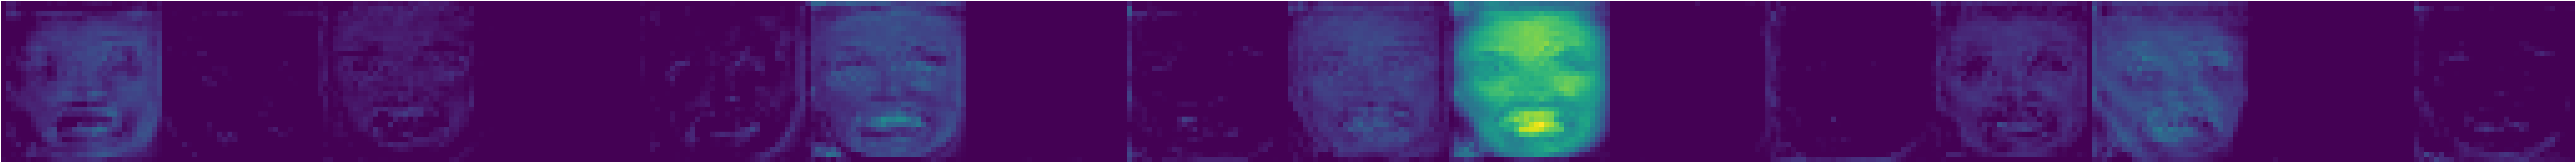

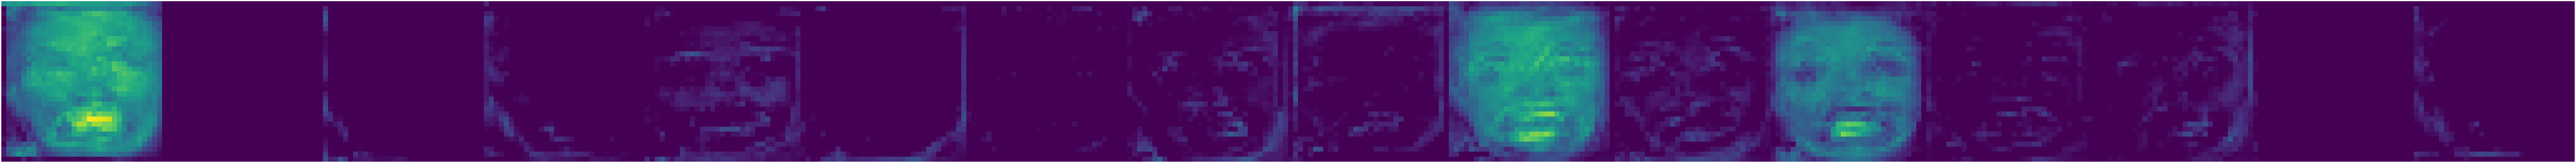

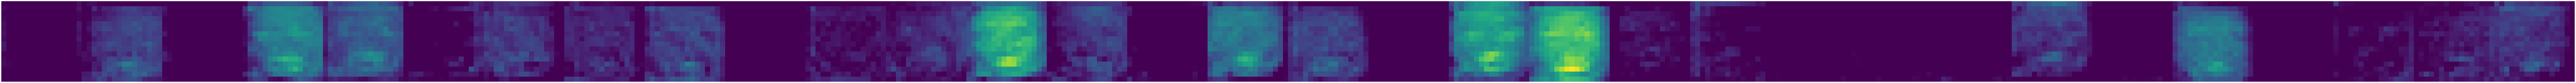

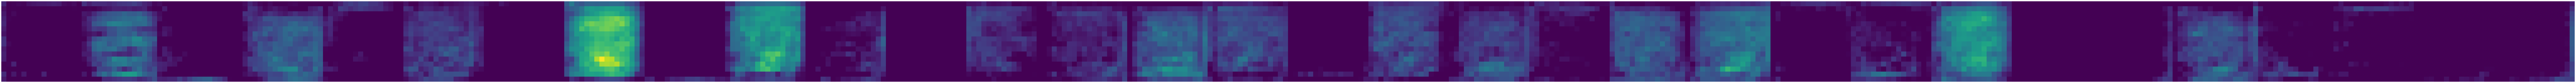

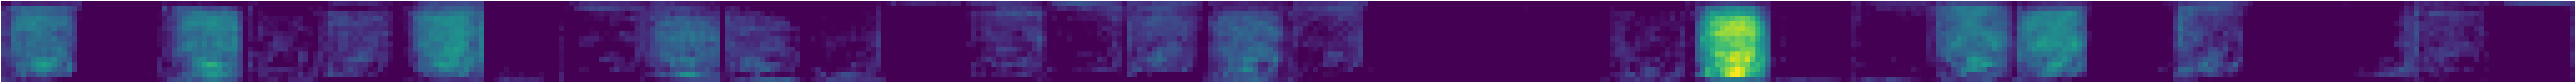

In [18]:
for i in range(len(f_map)):
    try:
        plt.figure(figsize=(256, 256))

        f_size = f_map[i].shape[1]
        n_channels = f_map[i].shape[-1]
        joint_maps = np.ones((f_size, f_size*n_channels))

        axis = plt.subplot(len(f_map,), 1, i+1)

        for j in range(n_channels):
            joint_maps[:, f_size*j: f_size*(j+1)] = f_map[i][..., j]

        plt.imshow(joint_maps[:, 0:512])
        plt.axis("off")

    except:
        time.sleep(100)
        continue

## GradCam

In [19]:
backbone = tf.keras.applications.efficientnet.EfficientNetB5(
    include_top=False,
    weights='imagenet',
    input_shape=(configrations["image_size"], configrations["image_size"], 3),

)

backbone.trainable = False

115263384/115263384 [==============================] - 1s 0us/step


In [20]:
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Dense(configrations["n_dense_1"], activation="relu")(x)
x = Dropout(rate=configrations["dropout_rate"])(x)
x = Dense(configrations["n_dense_2"], activation="relu")(x)
func_output = Dense(configrations["n_class"], activation="softmax")(x)

pre_trained = Model(backbone.inputs, func_output)

pre_trained.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling_1[0][0]']            
                                                                                                  
 rescaling_2 (Rescaling)        (None, 256, 256, 3)  0           ['normalization[0][0]']    

In [21]:
loss_function = CategoricalCrossentropy()
metrics = [CategoricalAccuracy(name="accuracy"), TopKCategoricalAccuracy(k=2, name="Top_K_Accuracy")]

In [22]:
pre_trained.compile(
    optimizer=Adam(learning_rate=configrations["learning_rate"]),
    loss="categorical_crossentropy", metrics=metrics) # sparse_categorical_crossentropy





# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [23]:
training_data = (
    train_data
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
#     .prefetch(tf.data.AUTOTUNE)

)

In [24]:
validation_data = (
    val_data
#     .prefetch(tf.data.AUTOTUNE)

)

In [25]:
check_point = ModelCheckpoint(
    "/kaggle/working/Emotion_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

redlr = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=2,
    min_lr=1e-5,
    verbose=1
)

es = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=1
)


In [26]:
history = pre_trained.fit(training_data,
                    validation_data=validation_data, 
                    verbose=1, 
                    epochs=configrations["n_epochs"],
                    callbacks=[redlr, es],
                    )


Epoch 1/50


2023-11-02 14:44:12.831560: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


213/213 [==============================] - 96s 362ms/step - loss: 0.6773 - accuracy: 0.7011 - Top_K_Accuracy: 0.9018 - val_loss: 0.5714 - val_accuracy: 0.7564 - val_Top_K_Accuracy: 0.9232 - lr: 0.0010
Epoch 2/50
213/213 [==============================] - 74s 346ms/step - loss: 0.5507 - accuracy: 0.7663 - Top_K_Accuracy: 0.9340 - val_loss: 0.5199 - val_accuracy: 0.7840 - val_Top_K_Accuracy: 0.9328 - lr: 0.0010
Epoch 3/50
213/213 [==============================] - 74s 347ms/step - loss: 0.4962 - accuracy: 0.7959 - Top_K_Accuracy: 0.9465 - val_loss: 0.4828 - val_accuracy: 0.7937 - val_Top_K_Accuracy: 0.9412 - lr: 0.0010
Epoch 4/50
213/213 [==============================] - 74s 345ms/step - loss: 0.4608 - accuracy: 0.8051 - Top_K_Accuracy: 0.9500 - val_loss: 0.4761 - val_accuracy: 0.7998 - val_Top_K_Accuracy: 0.9434 - lr: 0.0010
Epoch 5/50
213/213 [==============================] - 74s 346ms/step - loss: 0.4215 - accuracy: 0.8232 - Top_K_Accuracy: 0.9562 - val_loss: 0.4567 - val_accuracy: 

In [27]:
df = pd.DataFrame(history.history)
df

loss  accuracy  Top_K_Accuracy  val_loss  val_accuracy  \
0   0.677251  0.701133        0.901750  0.571388      0.756365   
1   0.550652  0.766289        0.933961  0.519939      0.784021   
2   0.496190  0.795852        0.946463  0.482831      0.793679   
3   0.460809  0.805118        0.949993  0.476086      0.799824   
4   0.421540  0.823209        0.956170  0.456739      0.809921   
5   0.391743  0.836447        0.961906  0.456008      0.811677   
6   0.361093  0.848213        0.965730  0.464556      0.808604   
7   0.350888  0.853949        0.966319  0.451786      0.814311   
8   0.327945  0.870422        0.971319  0.430563      0.828797   
9   0.309370  0.876452        0.972643  0.449558      0.823529   
10  0.298251  0.878953        0.975290  0.449230      0.824846   
11  0.277815  0.887483        0.975732  0.455338      0.833626   
12  0.278141  0.883512        0.974849  0.434355      0.835821   
13  0.260078  0.898662        0.979850  0.439418      0.836260   
14  0.249567  0.898220        0.981468  0.482397      0.836699   
15  0.254885  0.898073        0.979115  0.425556      0.838894   
16  0.235033  0.908516        0.982644  0.496273      0.836699   
17  0.220972  0.910281        0.984115  0.474756      0.830114   
18  0.228777  0.913223        0.982056  0.443639      0.841089   
19  0.222496  0.908222        0.982792  0.444877      0.845478   
20  0.216399  0.908810        0.984409  0.462335      0.843723   
21  0.209849  0.917341        0.986469  0.446042      0.854697   
22  0.197634  0.918665        0.986616  0.434196      0.856014   
23  0.198583  0.922194        0.986469  0.521068      0.828358   
24  0.191155  0.922783        0.985880  0.445712      0.853380   
25  0.184235  0.925283        0.987792  0.521376      0.835821   
26  0.162543  0.934990        0.991322  0.445805      0.856453   
27  0.143473  0.941315        0.992058  0.433488      0.861721   
28  0.138418  0.947345        0.991911  0.434549      0.861721   
29  0.134971  0.945874        0.994117  0.447893      0.860843   
30  0.130388  0.947933        0.993970  0.446419      0.862160   
31  0.124219  0.950875        0.994264  0.456548      0.860404   
32  0.124628  0.946021        0.991028  0.456206      0.862160   
33  0.118819  0.953376        0.993087  0.454766      0.864794   
34  0.118856  0.952934        0.992940  0.454566      0.866550   
35  0.114486  0.953081        0.992499  0.464086      0.860843   
36  0.120271  0.951611        0.993087  0.461399      0.861282   
37  0.117866  0.954552        0.994558  0.474881      0.860404   
38  0.116156  0.952787        0.992940  0.471539      0.861282   
39  0.122855  0.950728        0.992205  0.468293      0.862160   

    val_Top_K_Accuracy       lr  
0             0.923178  0.00100  
1             0.932836  0.00100  
2             0.941176  0.00100  
3             0.943371  0.00100  
4             0.940737  0.00100  
5             0.946005  0.00100  
6             0.947761  0.00100  
7             0.951273  0.00100  
8             0.949078  0.00100  
9             0.946883  0.00100  
10            0.948200  0.00100  
11            0.954785  0.00100  
12            0.953907  0.00100  
13            0.953029  0.00100  
14            0.953029  0.00100  
15            0.957858  0.00100  
16            0.956541  0.00100  
17            0.956980  0.00100  
18            0.956102  0.00100  
19            0.956980  0.00100  
20            0.956541  0.00100  
21            0.956541  0.00100  
22            0.960931  0.00100  
23            0.950834  0.00100  
24            0.960053  0.00100  
25            0.954785  0.00100  
26            0.959614  0.00010  
27            0.961370  0.00010  
28            0.959614  0.00010  
29            0.962687  0.00010  
30            0.961809  0.00010  
31            0.964442  0.00010  
32            0.962248  0.00010  
33            0.965320  0.00010  
34            0.963126  0.00010  
35            0.960492  0.00010  
36            0.959614  0.00010  
37       

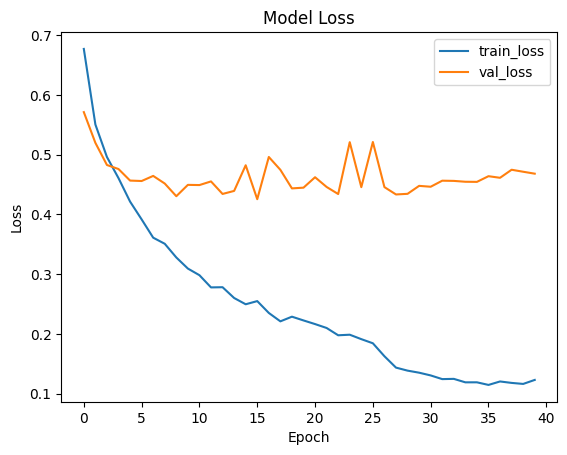

In [28]:
plt.plot(df["loss"])
plt.plot(df["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train_loss", "val_loss"])
plt.show()

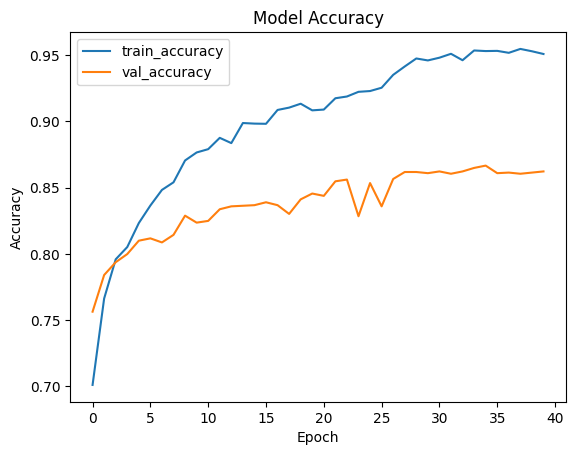

In [29]:
plt.plot(df["accuracy"])
plt.plot(df["val_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train_accuracy", "val_accuracy"])
plt.show()

In [30]:
pre_trained.evaluate(validation_data)

72/72 [==============================] - 18s 241ms/step - loss: 0.4683 - accuracy: 0.8622 - Top_K_Accuracy: 0.9627


[0.46829280257225037, 0.862159788608551, 0.9626865386962891]

In [31]:
def fit_image(images, model=pre_trained):

    img = tf.constant(images, dtype=tf.float32)
    im = tf.image.resize(img, (256, 256))  # Resize the image to match the model's input shape
    im = tf.expand_dims(im, axis=0)

    predicted_label = class_names[tf.argmax(model(im), axis=-1).numpy()[0]]

    return predicted_label


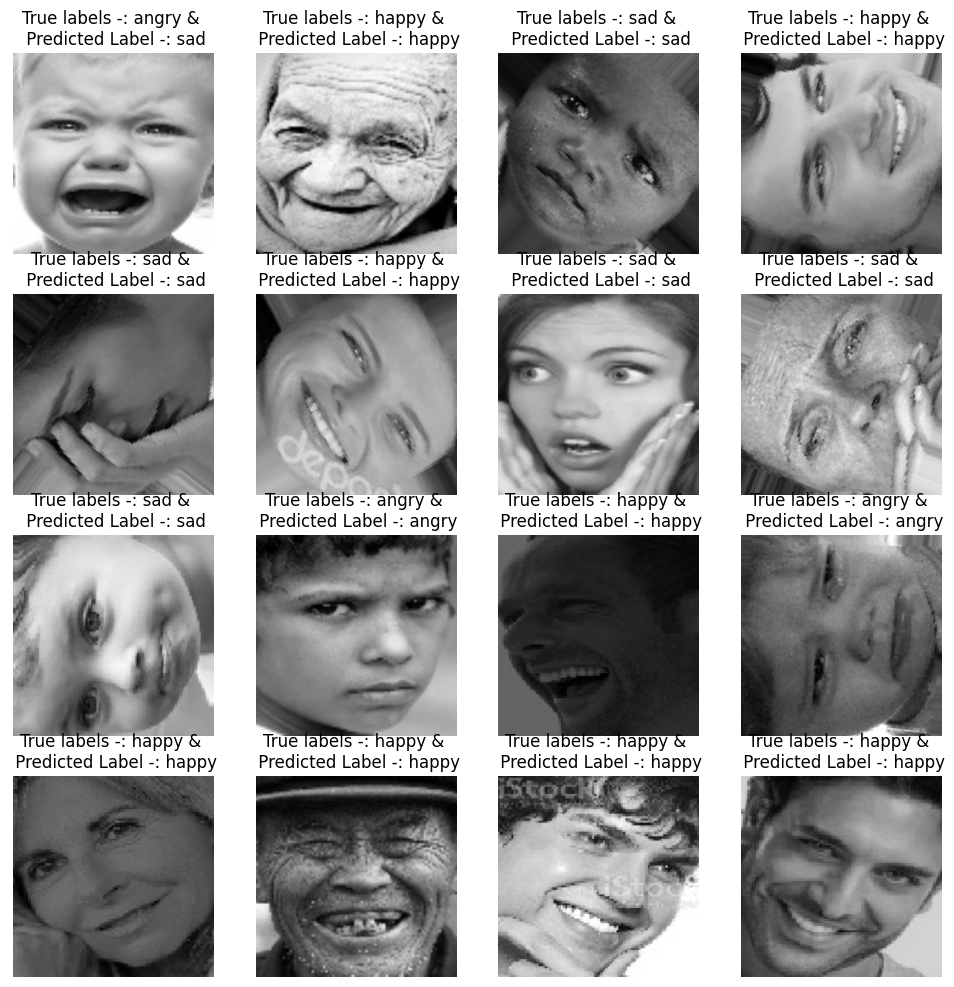

In [32]:
plt.figure(figsize = (12, 12) )

for images, labels in train_data.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i] / 255.0)

        true_label = class_names[tf.argmax(labels[i], axis=0).numpy()]
        predicted_label = fit_image(images[i])  # Pass the model as an argument

        plt.title(f"True labels -: {true_label} & \n Predicted Label -: {predicted_label}")
        plt.axis("off")


### **Confution Matrix**

In [33]:
predicted = []
labels = []

for im, label in validation_data.take(5):
    predicted.append(pre_trained(im))
    labels.append(label.numpy())

In [34]:
print(np.argmax(labels[:-1], axis=-1).flatten())
print(np.argmax(predicted[:-1], axis=-1).flatten())

[2 1 2 2 1 1 2 1 2 1 1 2 0 0 2 0 1 1 2 2 1 1 2 0 1 2 2 1 0 0 0 1 0 2 1 1 0
 1 2 1 1 1 2 0 2 1 1 2 2 2 0 2 1 1 0 1 2 1 0 2 2 1 1 1 2 2 1 2 0 1 1 1 0 2
 2 2 0 1 0 2 1 2 1 2 2 1 1 1 2 2 0 2 1 2 2 1 0 0 0 1 0 2 1 1 2 1 2 2 1 0 2
 1 2 1 2 2 2 2 0 2 0 1 0 2 1 2 0 1]
[2 1 2 2 1 1 2 1 2 1 1 2 0 0 2 0 1 1 1 2 1 1 2 0 1 2 0 1 0 0 2 2 0 1 1 1 0
 1 0 1 1 1 2 0 2 1 1 2 2 2 0 2 1 1 0 1 2 1 0 2 2 1 2 1 2 2 2 2 1 1 1 1 0 1
 1 2 0 2 2 2 1 2 2 2 2 1 1 1 2 2 0 2 1 1 2 1 1 0 0 1 0 2 1 1 2 1 2 2 1 0 2
 1 1 1 2 2 1 2 1 2 0 1 0 2 2 2 0 2]


In [35]:
lab = np.concatenate([np.argmax(labels[:-1], axis=-1).flatten(), np.argmax(labels[-1], axis=-1).flatten()])
pred = np.concatenate([np.argmax(predicted[:-1], axis=-1).flatten(), np.argmax(predicted[-1], axis=-1).flatten()])

[[28  3  4]
 [ 0 59  8]
 [ 2  7 49]]


Text(0.5, 58.7222222222222, 'prediction')

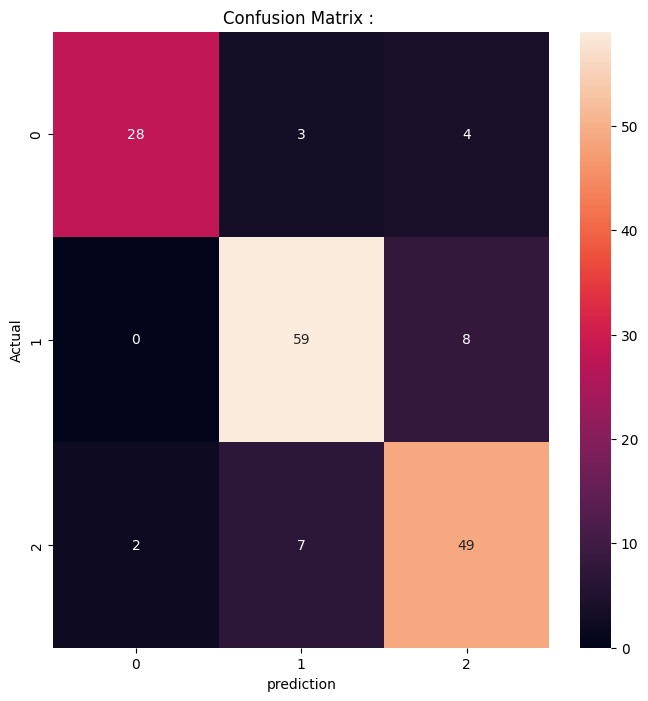

In [36]:
cm = confusion_matrix(lab, pred)
print(cm)

plt.figure(figsize=(8, 8))

sns.heatmap(cm, annot=True)

plt.title(f"Confusion Matrix : ")
plt.ylabel("Actual")
plt.xlabel("prediction")


In [37]:
pre_trained.save_weights("/kaggle/working/weight_model.h5")

In [38]:
pre_trained.load_weights("/kaggle/working/weight_model.h5")

### Model Inference on an Image

In this section, we perform model inference on an image using the pretrained model (`pre_trained`). The code loads an image, resizes it to the specified image size, and then passes it through the model to make predictions.

**Code Explanation**:
- The image is loaded using OpenCV (`cv.imread`). The path to the image file is provided as "/kaggle/input/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/test/angry/101071.jpg_rotation_1.jpg."

- The loaded image is resized to the dimensions specified in the project's configurations (`configurations["image_size"]`). This resizing step ensures that the image matches the input size expected by the model.

- The resized image is converted to a TensorFlow constant tensor (`im`) with a data type of float32. It is then expanded along the batch dimension using `tf.expand_dims` to create a batch of size 1.

- Model inference is performed by passing the image through the `pre_trained` model using `pre_trained.predict(im)`. The result (`pred`) is a prediction made by the model.

In [39]:
image = cv.imread("/kaggle/input/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/test/angry/101071.jpg_rotation_1.jpg")
test_image = cv.resize(image, (configrations["image_size"], configrations["image_size"]))
im = tf.constant(test_image, dtype=tf.float32)
im = tf.expand_dims(im, axis=0)
pred = pre_trained.predict(im)

1/1 [==============================] - 4s 4s/step


In [40]:
print(pred)

[[9.999068e-01 8.892964e-05 4.239364e-06]]


In [41]:
np.argmax(pred[0])

0

### Pretrained Model Layer Extraction

In this section, we extract a specific layer from a pretrained model to perform further analysis. The code focuses on extracting the `last_conv_layer` named "top_activation" from a pretrained model.

**Code Explanation**:
- The variable `last_conv_layer_name` is set to "top_activation," indicating the name of the layer we want to extract from the pretrained model.

- The `pre_trained` model is assumed to be a pretrained neural network model that includes the desired "top_activation" layer.

- We use `pre_trained.get_layer(last_conv_layer_name)` to retrieve the specified layer.

- A new model, `last_conv_layer_model`, is created using the `Model` class. This model takes the same inputs as the `pre_trained` model and has the extracted `last_conv_layer` as its output.

This code block is essential for isolating a specific layer from a pretrained model, which can be useful for various tasks, including visualization and analysis of intermediate model outputs.


In [42]:
last_conv_layer_name = "top_activation"
last_conv_layer = pre_trained.get_layer(last_conv_layer_name)
last_conv_layer_model = Model(pre_trained.inputs, last_conv_layer.output)

In [43]:
last_conv_layer_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling_1[0][0]']            
                                                                                                  
 rescaling_2 (Rescaling)        (None, 256, 256, 3)  0           ['normalization[0][0]']    

### Model Inference on an Image

In this section, we perform model inference on an image using the pretrained model (`pre_trained`). The code loads an image, resizes it to the specified image size, and then passes it through the model to make predictions.

**Code Explanation**:
- The image is loaded using OpenCV (`cv.imread`). The path to the image file is provided as "/kaggle/input/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/test/angry/101071.jpg_rotation_1.jpg."

- The loaded image is resized to the dimensions specified in the project's configurations (`configurations["image_size"]`). This resizing step ensures that the image matches the input size expected by the model.

- The resized image is converted to a TensorFlow constant tensor (`im`) with a data type of float32. It is then expanded along the batch dimension using `tf.expand_dims` to create a batch of size 1.

- Model inference is performed by passing the image through the `pre_trained` model using `pre_trained.predict(im)`. The result (`pred`) is a prediction made by the model.

This code block demonstrates how to prepare an image for inference and obtain predictions from a pretrained model.


In [46]:
classifier_layer_name = ['global_average_pooling2d', 
                         'dense', 
                         'dense_1', 
                         'dense_2']


In [47]:
classifier_input = Input(shape=(8, 8, 2048))
x = classifier_input

for layer_name in classifier_layer_name:
    x = pre_trained.get_layer(layer_name)(x)
    classifier_model = Model(classifier_input, x)

### Gradient Calculation for GradCAM

In this section, the code calculates gradients for the GradCAM (Gradient-weighted Class Activation Mapping) visualization. GradCAM is used to visualize which regions of the image are most relevant for making a particular prediction.

**Code Explanation**:
- A TensorFlow `GradientTape` context is initiated using `with tf.GradientTape() as tape`. This context allows for the calculation of gradients.

- The variable `last_conv_layer_output` represents the output of the last convolutional layer extracted from the pretrained model for the input image (`im`). This step is part of the GradCAM visualization process.

- The `classifier_model` is used to predict the class probabilities for the given image. The output of this model is stored in the variable `pred`.

- `top_pred_index` is calculated by finding the index of the class with the highest predicted probability using `tf.argmax(pred[0])`. This index represents the class with the highest confidence.

- `top_class_channel` is a tensor containing the predicted probability for the class with the highest confidence.

- Gradients of the `top_class_channel` with respect to the `last_conv_layer_output` are calculated using `tape.gradient(top_class_channel, last_conv_layer_output)`. These gradients are crucial for generating the GradCAM heatmap.

This code block is a key part of the GradCAM visualization process, where gradients are calculated to highlight the regions of the image that contribute the most to the highest predicted class probability.


In [48]:
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(im)
    pred = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(pred[0])
    print(top_pred_index)
    
    top_class_channel = pred[:, top_pred_index]
    
grads = tape.gradient(top_class_channel, last_conv_layer_output)

tf.Tensor(0, shape=(), dtype=int64)


In [49]:
grads.shape

TensorShape([1, 8, 8, 2048])

In [50]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()

In [51]:
print(pooled_grads.shape)

(2048,)


In [52]:
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(2048):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

In [53]:
print(last_conv_layer_output.shape)

(8, 8, 2048)


### Generating and Visualizing the GradCAM Heatmap

In this section, the code generates the GradCAM (Gradient-weighted Class Activation Mapping) heatmap and visualizes it. The heatmap highlights the regions of the image that are most relevant for making the highest predicted class.

**Explanation**:
- The variable `heatmap` is computed by summing the values along the last axis of `last_conv_layer_output`. This operation aggregates the feature maps and results in a single heatmap representing the importance of different regions of the image for the top predicted class.

- The `heatmap` is then resized using `cv.resize` to a size of (256, 256), creating a heatmap that matches the size of the input image.

- The `resized_heatmap` is visualized using `plt.matshow`. This heatmap is overlaid on top of the original input image (`im[0, :, :, 0]`) to highlight the regions that had the most influence on the highest predicted class.

- The multiplication by 2555 and the division by 255.0 in the visualization are likely for scaling and enhancing the visualization.

This code block is responsible for generating and visualizing the GradCAM heatmap, providing insights into which parts of the image contributed the most to the model's top prediction.


In [54]:
heatmap = np.sum(last_conv_layer_output, axis=-1)

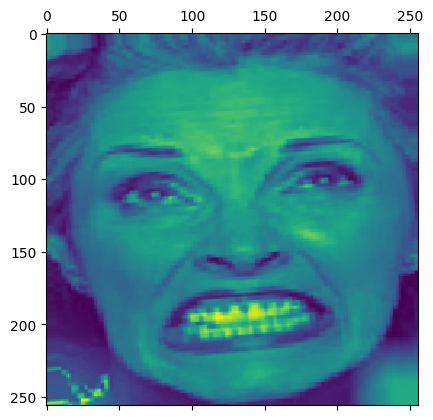

In [56]:
resized_heatmap = cv.resize(np.array(heatmap), (256, 256))
plt.matshow(resized_heatmap*2555 + im[0, :, :, 0]/255.0)

# Patch Encoder

In [57]:
image = cv.imread("/kaggle/input/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/test/angry/101071.jpg_rotation_1.jpg")
test_image = cv.resize(image, (configrations["image_size"], configrations["image_size"]))

### Image Patch Extraction

In this section, the code extracts patches from an input image for further analysis. Extracting patches allows for examining localized regions of the image.

**Code Explanation**:
- The `tf.image.extract_patches` function is used to extract patches from the input image. The parameters of this function are as follows:
  - `images`: The input image is expanded along a new axis to make it a batch of one image.
  - `sizes`: Specifies the size of the patches to be extracted. In this case, the size is set to [1, 16, 16, 1], which means each patch is a 16x16 pixel region.
  - `strides`: Determines the step size for moving the extraction window over the image. A stride of [1, 16, 16, 1] means that the window moves 16 pixels horizontally and 16 pixels vertically between each patch.
  - `rates`: Specifies dilation rates for the patches, which are set to [1, 1, 1, 1].
  - `padding`: The 'VALID' padding mode is used, which means no padding is added to the image edges, and only full patches are extracted.

This code block results in the extraction of patches from the input image, where each patch represents a 16x16 pixel region. These patches can be further analyzed or processed for various purposes, such as feature extraction or localized analysis.


In [78]:
patches = tf.image.extract_patches(images=tf.expand_dims(test_image, axis=0),
                           sizes=[1, 16, 16, 1],
                           strides=[1, 16, 16, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

In [79]:
print(patches.shape)

(1, 16, 16, 768)


### Image Patch Extraction

In this section, the code extracts patches from an input image for further analysis. Extracting patches allows for examining localized regions of the image.

**Code Explanation**:
- The `tf.image.extract_patches` function is used to extract patches from the input image. The parameters of this function are as follows:
  - `images`: The input image is expanded along a new axis to make it a batch of one image.
  - `sizes`: Specifies the size of the patches to be extracted. In this case, the size is set to [1, 16, 16, 1], which means each patch is a 16x16 pixel region.
  - `strides`: Determines the step size for moving the extraction window over the image. A stride of [1, 16, 16, 1] means that the window moves 16 pixels horizontally and 16 pixels vertically between each patch.
  - `rates`: Specifies dilation rates for the patches, which are set to [1, 1, 1, 1].
  - `padding`: The 'VALID' padding mode is used, which means no padding is added to the image edges, and only full patches are extracted.

This code block results in the extraction of patches from the input image, where each patch represents a 16x16 pixel region. These patches can be further analyzed or processed for various purposes, such as feature extraction or localized analysis.


In [81]:
plt.figure(figsize=(256, 256))
k = 0
for i in range(16):
    for j in range(16):
        
        ax = plt.subplot(16, 16, k+1)
        plt.imshow(tf.reshape(patches[0, i, j, :], (16, 16, 3)))
        plt.axis("off")
        k+=1


## Custom ResNet-34 Implementation

In this code, a custom implementation of the ResNet-34 deep learning model is defined using TensorFlow/Keras. This custom ResNet-34 model is designed for image classification tasks. Let's break down the key components of the code:

### CustomConv2D Layer
- `CustomConv2D` is a custom layer defined for 2D convolution with batch normalization.
- Parameters:
  - `n_filters`: Number of filters (output channels).
  - `kernel_size`: Size of the convolutional kernel.
  - `n_strides`: Stride for the convolution operation.
  - `padding`: Padding type for the convolution.
- It uses a `Conv2D` layer with ReLU activation and applies batch normalization.
- The `call` method defines how this layer processes input, including convolution and batch normalization.

### ResidualBlock Layer
- `ResidualBlock` is another custom layer designed for building residual blocks, which are fundamental components of ResNet models.
- Parameters:
  - `n_channels`: Number of output channels for the convolutional layers in the block.
  - `n_strides`: Stride for the first convolutional layer within the block.
- The `ResidualBlock` consists of three convolutional layers (`CustomConv2D`) with ReLU activation.
- Depending on `n_strides`, it may apply an additional convolution for downsampling the input.
- The `call` method defines how this block processes input, including the convolutional layers and skip connections.

### Resnet34 Model
- The `Resnet34` model is the custom implementation of the ResNet-34 architecture.
- It is designed for image classification tasks.
- Key components of the model include:
  - Initial convolutional layer (`conv_1`) with specific settings.
  - Max-pooling layer (`max_pool`).
  - A series of residual blocks in different stages (`conv_2_x`, `conv_3_x`, `conv_4_x`, `conv_5_x`).
  - Global average pooling layer (`global_pool`).
  - Fully connected layer (`fc_3`) with a softmax activation function, typically used for classification tasks.

The `call` method of the `Resnet34` model defines the forward pass through various layers and blocks, ultimately leading to the final classification using the fully connected layer.

This custom ResNet-34 implementation can be used for image classification and other computer vision tasks where deep learning models are required.



In [63]:
class CustomConv2D(Layer):
    def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
        super(CustomConv2D, self).__init__()
        
        self.conv2d = Conv2D(
            filters = n_filters,
            kernel_size = kernel_size,
            strides = n_strides,
            padding = padding,
            activation = 'relu'
        )
        
        self.batchN = BatchNormalization()
    
    def call(self, x, training = True):
        
        x = self.conv2d(x)
        output = self.batchN(x, training)
        
        return output

class ResidualBlock(Layer):
    def __init__(self, n_channels, n_strides = 1):
        super(ResidualBlock, self).__init__(name = 'residual_block')
        
        self.dotted = (n_strides != 1)
        
        self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = "same")
        self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = "same")
        
        self.activation = Activation('relu')
        
        if self.dotted:
            self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)
            
    def call(self, input, training):
        x = self.custom_conv_1(input, training)
        x = self.custom_conv_2(x, training)

        if(self.dotted):
            x_add = self.custom_conv_3(input, training)
            x_add = Add()([x, x_add])
        else:
            x_add = Add()([x, input])
        output = self.activation(x_add)
        return output
        
class Resnet34(Model):
    def __init__(self):
        super(Resnet34, self).__init__(name = 'resnet_34')
        
        self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')
        self.max_pool = MaxPooling2D(3, 2)
        
        self.conv_2_1 = ResidualBlock(64)
        self.conv_2_2 = ResidualBlock(64)
        self.conv_2_3 = ResidualBlock(64)
        
        self.conv_3_1 = ResidualBlock(128, 2)
        self.conv_3_2 = ResidualBlock(128)
        self.conv_3_3 = ResidualBlock(128)
        self.conv_3_4 = ResidualBlock(128)
        
        self.conv_4_1 = ResidualBlock(256, 2)
        self.conv_4_2 = ResidualBlock(256)
        self.conv_4_3 = ResidualBlock(256)
        self.conv_4_4 = ResidualBlock(256)
        self.conv_4_5 = ResidualBlock(256)
        self.conv_4_6 = ResidualBlock(256)
        
        self.conv_5_1 = ResidualBlock(512, 2)
        self.conv_5_2 = ResidualBlock(512)
        self.conv_5_3 = ResidualBlock(512)

        self.global_pool = GlobalAveragePooling2D()
        
        self.fc_3 = Dense(configrations['n_class'], activation = 'softmax')
        
    def call(self, x, training = True):
        x = self.conv_1(x, training)
        x = self.max_pool(x)
        
        x = self.conv_2_1(x, training)
        x = self.conv_2_2(x, training)
        x = self.conv_2_3(x, training)
        
        x = self.conv_3_1(x, training)
        x = self.conv_3_2(x, training)
        x = self.conv_3_3(x, training)
        x = self.conv_3_4(x, training)
        
        x = self.conv_4_1(x, training)
        x = self.conv_4_2(x, training)
        x = self.conv_4_3(x, training)
        x = self.conv_4_4(x, training)
        x = self.conv_4_5(x, training)
        x = self.conv_4_6(x, training)
        
        x = self.conv_5_1(x, training)
        x = self.conv_5_2(x, training)
        x = self.conv_5_3(x, training)
        x = self.global_pool(x)
        output = self.fc_3(x)
        
        return output

In [64]:
input_data = Input(shape = (configrations['image_size'], configrations['image_size'], 3), name = 'input_image')
resnet34 = Resnet34()
resnet34(input_data, training = True)
resnet34.summary()

Model: "resnet_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_conv2d (CustomConv2D  multiple                 9728      
 )                                                               
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 residual_block (ResidualBlo  multiple                 74368     
 ck)                                                             
                                                                 
 residual_block (ResidualBlo  multiple                 74368     
 ck)                                                             
                                                                 
 residual_block (ResidualBlo  multiple                 74

In [65]:
resnet34.compile(
    optimizer = Adam(configrations['learning_rate']*10),
    loss = loss_function,
    metrics = metrics
)

In [66]:
check_point = ModelCheckpoint(
    "/kaggle/working/Emotion_best_resnet34_model.pkl",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

In [67]:
history = resnet34.fit(
    train_data,
    validation_data = val_data,
    epochs = configrations['n_epochs'],
    verbose = 1, 
    callbacks=[check_point, redlr, es],
)

Epoch 1/50
213/213 [==============================] - ETA: 0s - loss: 1.5009 - accuracy: 0.5394 - Top_K_Accuracy: 0.8006
Epoch 1: val_accuracy improved from -inf to 0.43371, saving model to /kaggle/working/Emotion_best_resnet34_model.pkl
213/213 [==============================] - 97s 330ms/step - loss: 1.5009 - accuracy: 0.5394 - Top_K_Accuracy: 0.8006 - val_loss: 1.2292 - val_accuracy: 0.4337 - val_Top_K_Accuracy: 0.7046 - lr: 0.0100
Epoch 2/50
213/213 [==============================] - ETA: 0s - loss: 1.1151 - accuracy: 0.4815 - Top_K_Accuracy: 0.7778
Epoch 2: val_accuracy improved from 0.43371 to 0.49166, saving model to /kaggle/working/Emotion_best_resnet34_model.pkl
213/213 [==============================] - 67s 315ms/step - loss: 1.1151 - accuracy: 0.4815 - Top_K_Accuracy: 0.7778 - val_loss: 1.1938 - val_accuracy: 0.4917 - val_Top_K_Accuracy: 0.7757 - lr: 0.0100
Epoch 3/50
213/213 [==============================] - ETA: 0s - loss: 1.0097 - accuracy: 0.5177 - Top_K_Accuracy: 0.800

### 1. Saved the weights of the `resnet34` model to a file named "weight_resnet34_model.pkl".
### 2. Saved the entire model, including its architecture, weights, and training configuration, to a file named "resnet34_model.pkl".
### 3. Loaded the saved model from the "resnet34_model.pkl" file using the `tf.saved_model.load` function.

In [68]:
resnet34.save_weights("/kaggle/working/weight_resnet34_model.pkl")

In [69]:
resnet34.save("/kaggle/working/resnet34_model.pkl")

In [70]:
loaded_model = tf.saved_model.load("/kaggle/working/resnet34_model.pkl")
